In [2]:
import pandas as pd
import random
import itertools
import numpy as np
import time 
import pickle
from scipy.stats import ttest_ind, chi2_contingency, fisher_exact, ranksums
from scipy.stats import pearsonr, spearmanr
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd drive/My\ Drive/Broad/data

/content/drive/My Drive/Broad/data


In [4]:
column_names = pd.read_csv('../data/columns for X.csv',header = None)
column_names = list(column_names[0])

rows = pd.read_csv('../data/rows for X.csv',header = None)
cell_type = list(rows[0])
cell_type = [val.lower() for val in cell_type]

gene_list_hm = pd.read_csv('../data/110920_new drug list v1.csv', header = None)
gene_list_hm = list(gene_list_hm[0])

In [ ]:
df_hm = pd.read_csv('../data/X.csv',names = column_names, usecols = gene_list_hm)
df_hm['cell_type'] = cell_type

In [ ]:
df_hm.columns

Index(['ATAD3B', 'PRKCZ', 'UBR4', 'SLC9A1', 'MACF1', 'EPS15', 'NRAS', 'NOTCH2',
       'FCGR2A', 'SLC45A3',
       ...
       'SLC27A1', 'LPAR2', 'PLAUR', 'CYTH2', 'PTPRH', 'PI4KA', 'MAPK1', 'MIF',
       'BACE2', 'cell_type'],
      dtype='object', length=126)

### mean heatmap

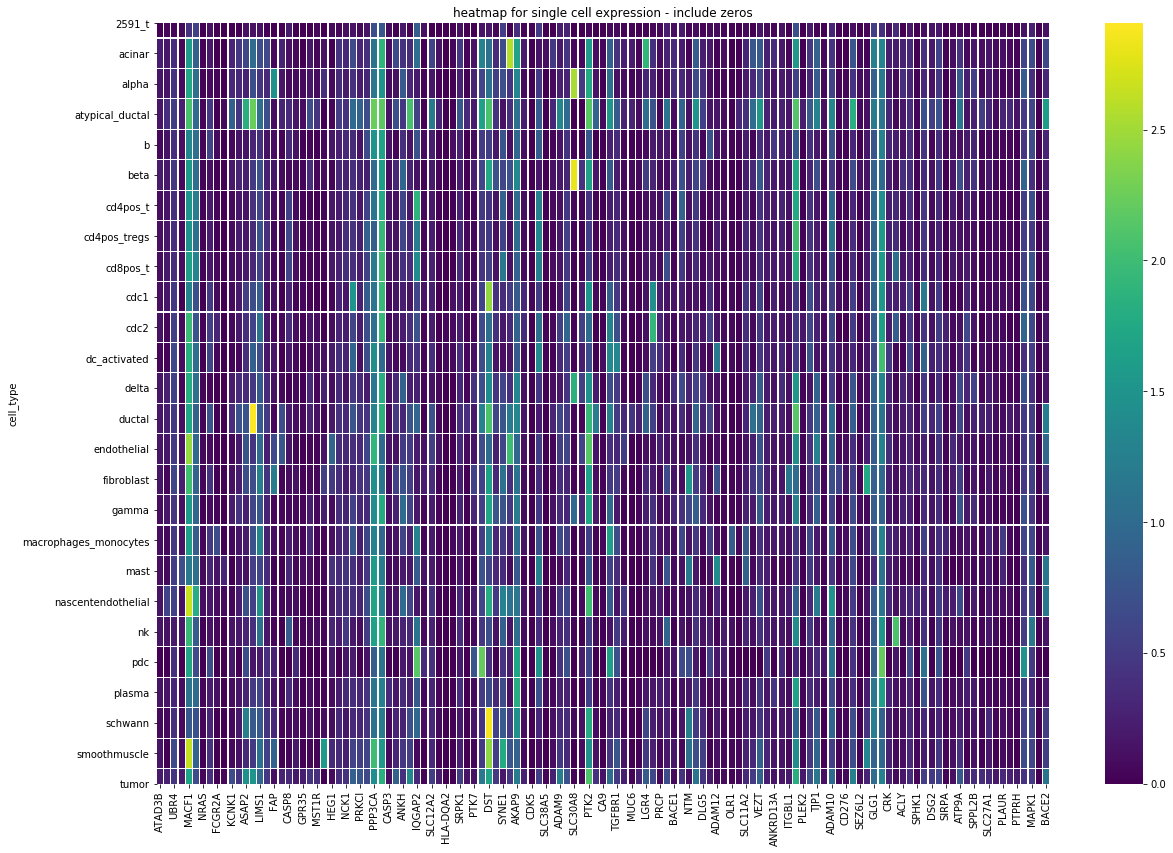

In [ ]:
df_hm_mean = df_hm.groupby('cell_type').mean()

plt.figure(figsize = (20,14))
sns.heatmap(df_hm_mean,linewidth = .1, cmap="viridis")
plt.title('heatmap for single cell expression - include zeros')
plt.savefig('outputs/single_cell_heatmaps/novel_gene_heatmap_with_zeros.png')

# Correlation Study

In [5]:
subset = 'novel'
pvalue_file = 'tumor_ductal_statistical_testing_novel_v1.csv'

df_pvalues = pd.read_csv(os.path.join('../data',pvalue_file))
gene_list = list(df_pvalues[df_pvalues['ttest_pvalue'] < .05]['gene'])

In [6]:
column_names = pd.read_csv('../data/columns for X.csv',header = None)
column_names = list(column_names[0])

rows = pd.read_csv('../data/rows for X.csv',header = None)
cell_type = list(rows[0])
cell_type = [val.lower() for val in cell_type]

In [7]:
df = pd.read_csv('../data/X.csv',names = column_names, usecols = gene_list)
df = df[gene_list]
df['cell_type'] = cell_type
df_tumor = df[df['cell_type'] == 'tumor']
df_tumor.shape
df_tumor.replace(0,np.nan, inplace = True)
df_tumor_dropna = df_tumor.dropna(how = 'all', subset = gene_list)
df_tumor_dropna.shape

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


(43752, 67)

In [8]:
index_dict = {}
for gene in gene_list:
    index_dict[gene] = list(df_tumor[~df_tumor[gene].isna()].index)

In [9]:
pickle.dump(index_dict, open("../outputs/{}_correlation_gene_index_dict.pkl".format(subset), "wb"))  # save it into a file named save.p

In [10]:
len(gene_list)

66

In [12]:
start = time.time()

for gene in gene_list:
    
    print('start with {}'.format(gene))
    skiprows = [i for i in np.arange(88031) if i not in index_dict[gene]]
    df_g = pd.read_csv('../data/X.csv',names = column_names, skiprows = skiprows, usecols = [gene])
    df_g.replace(0,np.nan, inplace = True)
    df_g.dropna(axis = 1, thresh = 100, inplace = True)
    
    print('data read - shape = {}'.format(df_g.shape))

start with ATAD3B


KeyboardInterrupt: ignored

In [11]:
start = time.time()

for gene in gene_list:
    
    print('start with {}'.format(gene))
    skiprows = [i for i in np.arange(88031) if i not in index_dict[gene]]
    df_g = pd.read_csv('../data/X.csv',names = column_names, skiprows = skiprows)
    df_g.replace(0,np.nan, inplace = True)
    df_g.dropna(axis = 1, thresh = 100, inplace = True)
    
    print('data read - shape = {}'.format(df_g.shape))
    gene_col_list = []
    r_pearson_list = []
    r_spearman_list = []
    p_pearson_list = []
    p_spearman_list = []
    n_rows_list = []

    for col in df_g.columns:
        filename = '{}_correlation.csv'.format(gene)
        if col not in gene:
            df_subset = df_g[[gene,col]]
            df_subset_filtered = df_subset[~df_subset[col].isna()]
            r_pearson, p_pearson = pearsonr(df_subset_filtered[gene], df_subset_filtered[col])
            r_spearman, p_spearman = spearmanr(df_subset_filtered[gene], df_subset_filtered[col])

            n_rows = df_subset_filtered.shape[0]
            gene_col_list.append(col)
            r_pearson_list.append(r_pearson)
            p_pearson_list.append(p_pearson)

            r_spearman_list.append(r_spearman)
            p_spearman_list.append(p_spearman)        

            n_rows_list.append(n_rows)
            
    df_gene_corr = pd.DataFrame({'gene':gene_col_list,
                                 'r_pearson':np.round(r_pearson_list,5),
                                 'p_pearson':p_pearson_list,
                                 'r_spearman':np.round(r_spearman_list,5),
                                 'p_spearman':p_spearman_list,
                                 'n_rows_nonzero' : n_rows_list
                                })
    df_gene_corr.sort_values(by= 'r_pearson', ascending = False, inplace = True)
    df_gene_corr.to_csv('../outputs/single_cell_correlation/{}/{}'.format(subset,filename),index = False)
    
    print('done with {} at {:.3f}'.format(gene, time.time()- start))

start with ATAD3B


KeyboardInterrupt: ignored